In [14]:
# import os
# os.environ["KERAS_BACKEND"] = "tensorflow"
# import keras
# print(keras.backend.backend())

In [15]:
#1. import package
import mlflow
from tensorflow.keras import layers, losses, metrics, activations, callbacks, initializers, regularizers, optimizers, Sequential
import numpy as np
import pandas as pd
import pickle, datetime
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt

In [16]:
# Data Loading
URL = 'https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv'
df = pd.read_csv(URL)


In [17]:
print(df.info())
print(df.head(1))
print(df['text'][4])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None
  category                                               text
0     tech  tv future in the hands of viewers with home th...
ocean s twelve raids box office ocean s twelve  the crime caper sequel starring george clooney  brad pitt and julia roberts  has gone straight to number one in the us box office chart.  it took $40.8m (£21m) in weekend ticket sales  according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one  national treasure  into third place. wesley snipes  blade: trinity was in second  taking $16.1m (£8.4m). rounding out the top five was animated fable the polar express  starri

the feature category is not a categorical feature. we cannot do much for text, but we can inspect for 'category' column.

In [18]:
#Data Inspection
print("number of categories:", df['category'].nunique())
print(df['category'].value_counts())
print("Missing values:", df.isna().sum())
print("duplicates:", df.duplicated().sum())

number of categories: 5
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64
Missing values: category    0
text        0
dtype: int64
duplicates: 99


In [19]:
print(df['category'][df['text'].duplicated()].value_counts())

category
tech             54
entertainment    17
politics         14
business          7
sport             7
Name: count, dtype: int64


In [20]:
#4. Data Preprocessing
features = df['text'].values
label = df['category'].values

In [21]:
# label is string, so need to encode first
encoder = preprocessing.LabelEncoder()
label_encoded = encoder.fit_transform(label)
print(label_encoded[:5])

[4 0 3 3 1]


In [22]:

# splitting
SEED = 42
X_train, X_split, y_train, y_split = model_selection.train_test_split(features, label_encoded, train_size=0.7, random_state=SEED)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_split, y_split, train_size=0.5, random_state=SEED)

print(X_train.shape, X_val.shape, X_test.shape)

(1557,) (334,) (334,)


## A bit about NLP
- The next step is to process the feature which is of language data type
- For language task, the basic preprocessing techniques are:
1. Tokenization: The process of converting words into integers called token. The range of integers used depends on a hyperparameter called vocabulary size. Any words that are outside of the vocab is called OOV - Out of vocab. and they will all be treated equally as the same type of token

2. Padding and truncating: This process will either expand or trim the language array so that each data point has a consistent length of words in it. Because each rows of data might not have the same length.

3. Embedding : This process converts token into a long vector known as embedding. This vector is a special representation of the language which the model can sort of differentiate the meaning of different words. (We also have  embedding being used in face recognition task) - Word2Vec. This step will be the one that is served as a feature to the model.

- Each word (each embedding) is a feature. It is treated as a time step. First word - time step 1, second word - time step 2 etc...



In [23]:
mlflow.set_experiment("NLP Classification task")

<Experiment: artifact_location='file:///Users/athirahsofea/mlflow_with_deepLearning/mlruns/818863518837143279', creation_time=1735619517883, experiment_id='818863518837143279', last_update_time=1735619517883, lifecycle_stage='active', name='NLP Classification task', tags={}>

In [24]:
#preprocessing our text
#[A] Tokenization
# can use Text Vecotization. 1. max_tokens = size of vocabulary. "We are just gonna look at 500 different words at max" . 2. output_sequence_length . All of the texts have inconsisten length, the moment we define a fix number here, every text will forced to undergo either padding/truncating process.
tokenizer = layers.TextVectorization(max_tokens=5000, output_sequence_length=200)
tokenizer.adapt(X_train)

In [25]:
# [Optional to test out the tokenizer]
sample_text = X_train[:2]
sample_token = tokenizer(sample_text)
print(sample_text)
print(sample_token)

['uganda bans vagina monologues uganda s authorities have banned the play the vagina monologues  due to open in the capital  kampala this weekend.  the ugandan media council said the performance would not be put on as it promoted and glorified acts such as lesbianism and homosexuality. it said the production could go ahead if the organisers  expunge all the offending parts . but the organisers of the play say it raises awareness of sexual abuse against women.  the play promotes illegal  unnatural sexual acts  homosexuality and prostitution  it should be and is hereby banned   the council s ruling said.  the show  which has been a controversial sell-out around the world  explores female sexuality and strength through individual women telling their stories through monologues. some parliamentarians and church leaders are also siding with the media council  uganda s new vision newspaper reports.  the play is obscene and pornographic although it was under the guise of women s liberation   m

there are lots of 1, so 1 might be the out of vocabulary. but which one comes first? tokenize or padding/truncating.

In [26]:
# Embedding (keras embedding layer)
# input_dim = size of vocab (match with the max_tokens)
# output_dim = what comes out of embedding is a vector. How long our number is (our vector) is defined by this param

embedding = layers.Embedding(5000, 64)

In [27]:
# Model Development
# we use bidirectional LSTM - to help deal with the ambiguity of the language
model = Sequential()
#(A) NLP layers
model.add(tokenizer)
model.add(embedding)
#(B) RNN layers
#model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True))) #True because we passing onto the next LSTM layer
model.add(layers.Bidirectional(layers.LSTM(32))) #return_seq false because it is many to one, output is 1.
#(C) Dense layers
model.add(layers.Dense(5, activation='softmax'))
#model.summary()

In [28]:
# model compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
#model training
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)

2024/12/31 13:37:20 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential' has no defined input shape yet.
2024/12/31 13:37:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: 'NoneType' object is not subscriptable


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2481 - loss: 1.5906

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.2491 - loss: 1.5897 - val_accuracy: 0.4731 - val_loss: 1.2268
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5473 - loss: 1.1278

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5480 - loss: 1.1264 - val_accuracy: 0.5629 - val_loss: 0.9498
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6768 - loss: 0.7559

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6773 - loss: 0.7552 - val_accuracy: 0.7216 - val_loss: 0.7243
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7981 - loss: 0.5426

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7992 - loss: 0.5413 - val_accuracy: 0.8623 - val_loss: 0.5509
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9430 - loss: 0.3015

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9430 - loss: 0.3011 - val_accuracy: 0.8653 - val_loss: 0.4660
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9528 - loss: 0.2168

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9529 - loss: 0.2166 - val_accuracy: 0.9192 - val_loss: 0.3634
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9805 - loss: 0.1188

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9805 - loss: 0.1186 - val_accuracy: 0.9012 - val_loss: 0.2797
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9895 - loss: 0.0640

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9895 - loss: 0.0639 - val_accuracy: 0.9251 - val_loss: 0.2695
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9894 - loss: 0.0564 - val_accuracy: 0.9072 - val_loss: 0.2909
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9973 - loss: 0.0239 - val_accuracy: 0.9162 - val_loss: 0.2847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


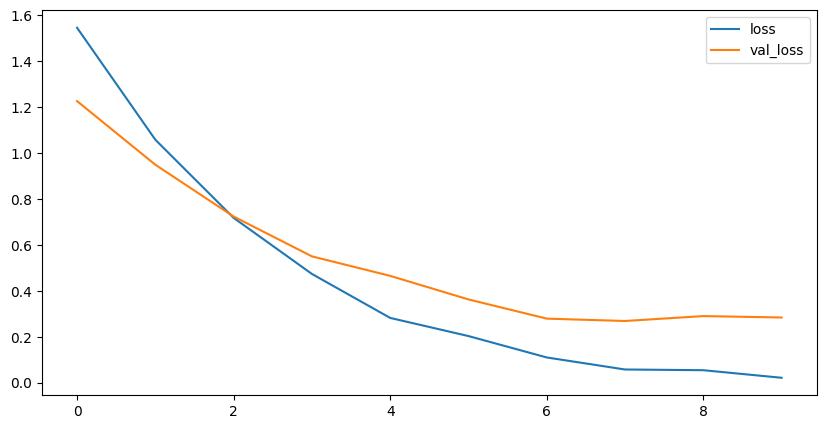

In [30]:
# plot val_loss against loss with the epochs on x axis
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [31]:
# evaluate our model
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9211 - loss: 0.2988


[0.28951817750930786, 0.9221556782722473]

we can also utilise mlflow for NLP

In [32]:
#save the label encoder as pickle
with open("news_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)